# Antidiagonal analysis

The goal is to compute the mean values on each secondary diagonals removing the value closed to the primary diagonal and plot it to compare the intensity of the diagonal. Example with *Muribaculum intestinale*.

In [1]:
import bacchus.antidiagonal as bca
import bacchus.io as bcio
import bacchus.plot as bcp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

os.chdir("/data/oligomm/muribaculum_intestinale/in_vitro_R1/")
title = 'M. intestinale'
condition = "in vitro R1"
prefix = "m_intestinale"

In [2]:
# Import te matrix, bin it at 5kb and nomrlaize it.

M = bcio.build_map(["abs_fragments_contacts_weighted.txt"], "fragments_list.txt", 2000)

INFO :: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO :: NumExpr defaulting to 8 threads.


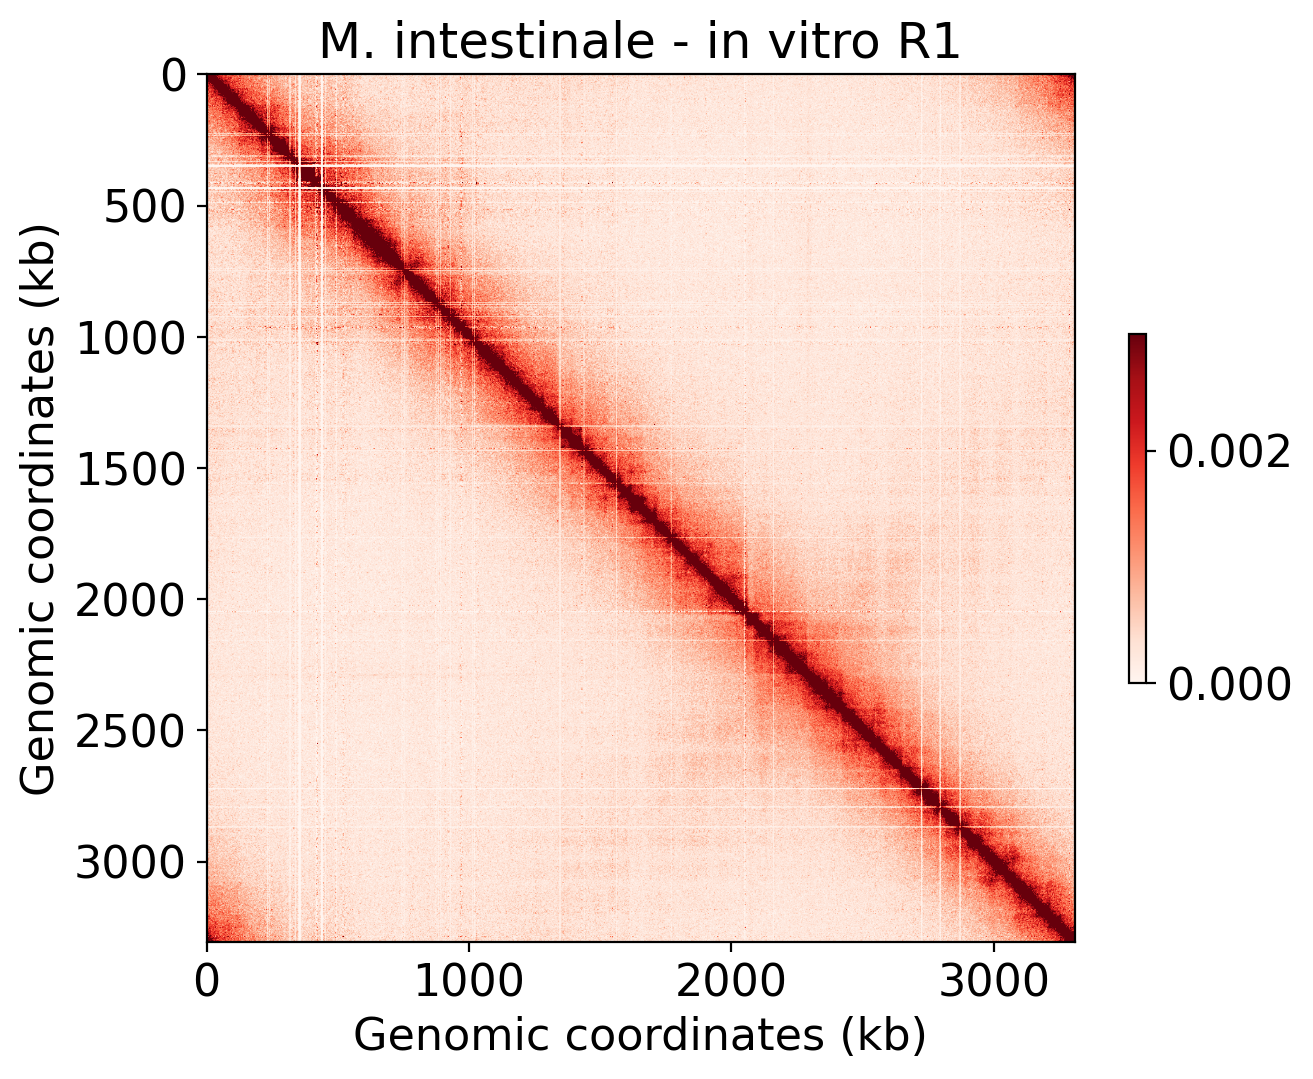

In [3]:
bcp.contact_map(M, dpi=200, binning=2000, title=title + ' - ' + condition, vmax=98)

In [4]:
# Rotate the matrix to have the secondary diagonal as primary diagonal
N = np.rot90(M)

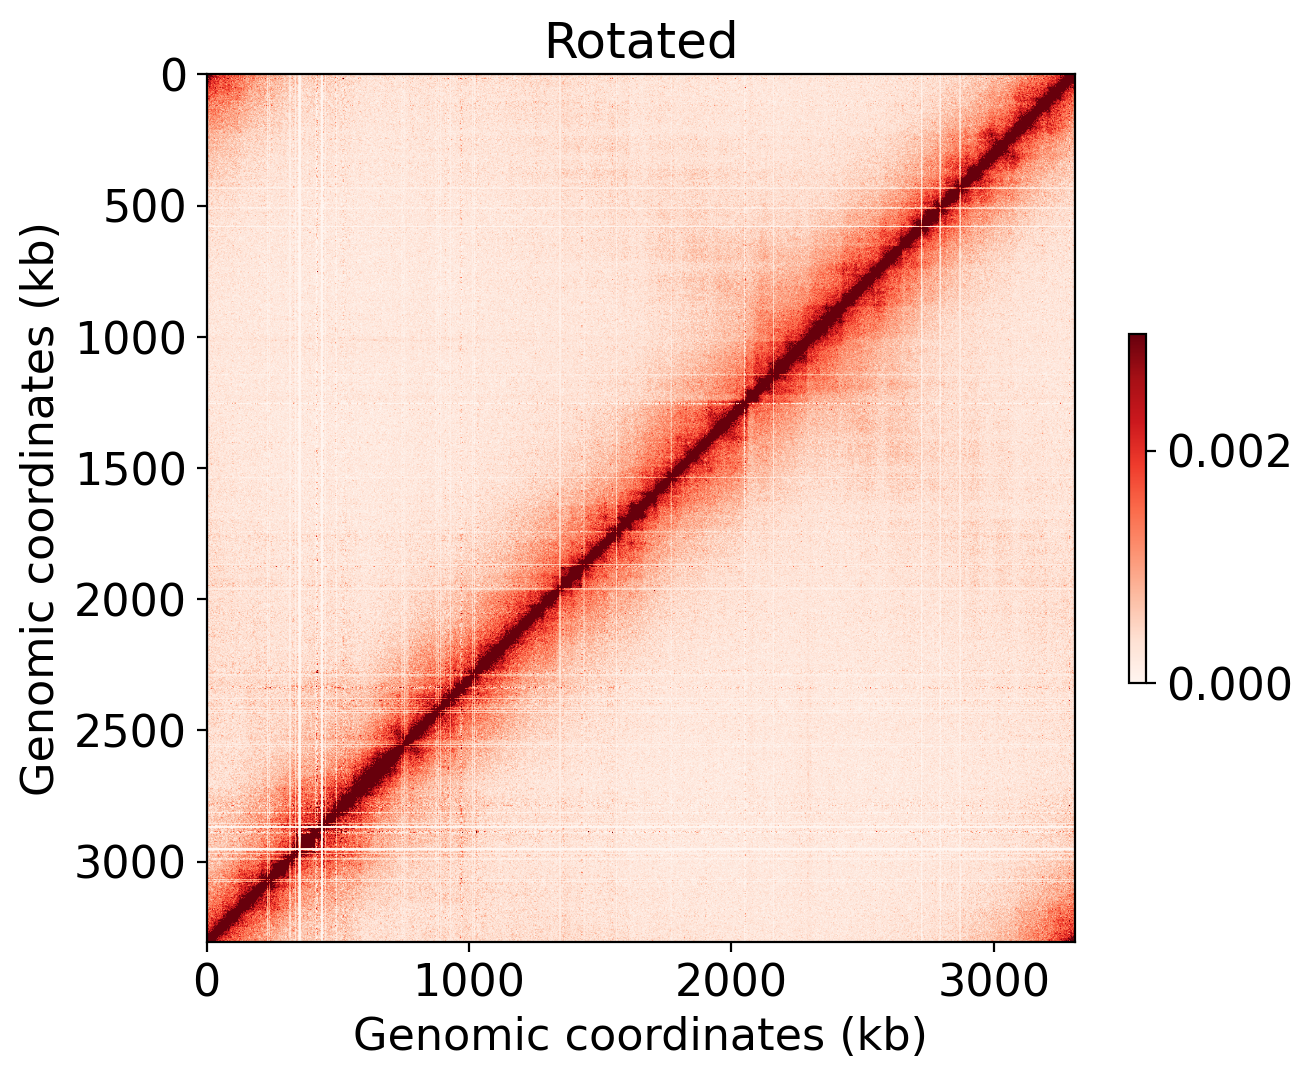

In [5]:
bcp.contact_map(N, dpi=200, binning=2000, title="Rotated", vmax=98)

## Full antidiagonals

In [6]:
# Compute the antidiagonal score.Full option will take the full antidiagonal. 
values = bca.compute_antidiagonal(M, full=True)

In [7]:
# Extract parS and oriter positions from previous analysis.
ori = pd.read_csv("../cov/ratio_ori_ter.txt", sep="\t", header=None).iloc[1,1]
pars = np.array(pd.read_csv("../annotation/" + prefix + "_pars.bed", sep="\t", header=None).iloc[:,1])

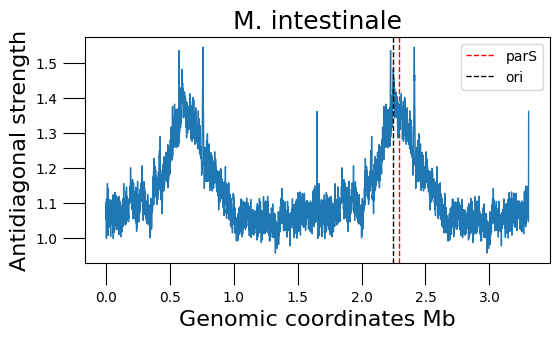

In [8]:
bcp.antidiagonal_plot(values, binning=2000, title=title, pars_pos=pars)
plt.axvline(x=ori / 1_000_000, linewidth=1, color="black", linestyle="dashed", label="ori")
plt.legend()

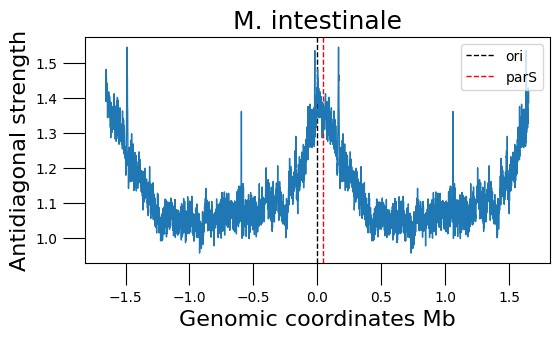

In [9]:
bcp.antidiagonal_plot(values, binning=2000, title=title, ori_pos=ori, pars_pos=pars)

## Partial antidiagonals

In [10]:
# Compute the antidiagonal score. Here we do on half the antidiagonal
# to be able to differentiate the two half of the genome. Indeed using
# the partial allow us to compute score only on the first half of the 
# genome.
values = bca.compute_partial_antidiagonal(N, np.shape(M)[0] // 4)
values = values / np.nanpercentile(values, 1)

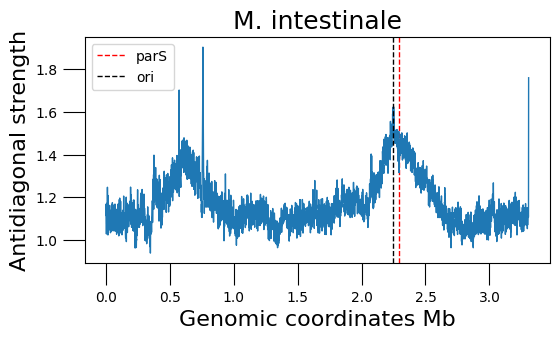

In [11]:
bcp.antidiagonal_plot(values, binning=2000, title=title, pars_pos=pars)
plt.axvline(x=ori / 1_000_000, linewidth=1, color="black", linestyle="dashed", label="ori")
plt.legend()

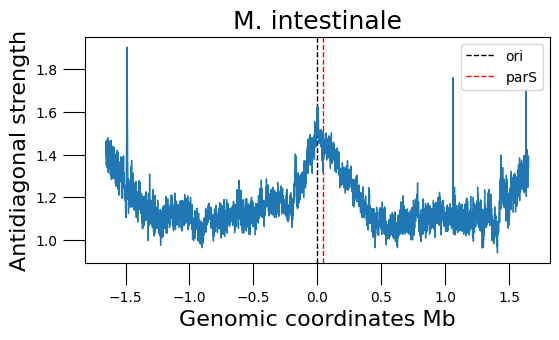

In [12]:
bcp.antidiagonal_plot(values, binning=2000, title=title, ori_pos=ori, pars_pos=pars)

## Scalogram analysis

In [13]:
scal_val = bca.compute_antidiagonal_scalogram(M, 2000, [10_000*2**x for x in np.arange(1,8)])

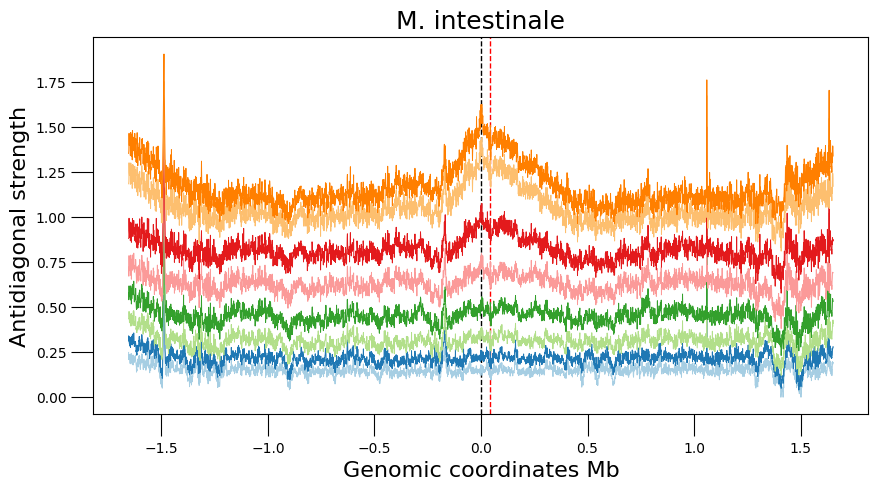

In [14]:
bcp.antidiagonal_scalogram(scal_val, binning=2000, title=title, ori_pos=ori, pars_pos=pars, )

## All bacteria antidiagonals

In [15]:
list_bacteria = [
    "acutalibacter_muris",
    "akkermansia_muciniphila",
    "bacteroidetes_caecimuris",
    "bifidobacterium_animalis",
    "blautia_coccoides",
    "clostridium_clostridioforme",
    "clostridium_innocuum",
    "enterococcus_faecalis",
    "flavonifractor_plautii",
    "lactobacillus_reuteri",
    "muribaculum_intestinale",
    "turicimonas_muris",
]

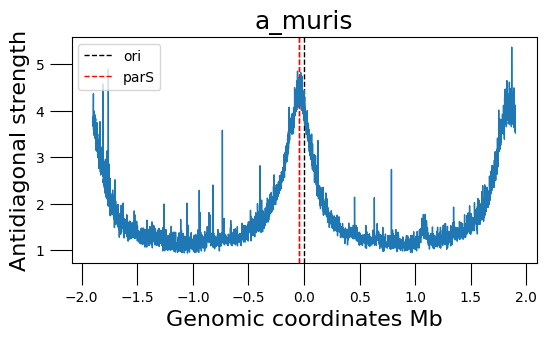

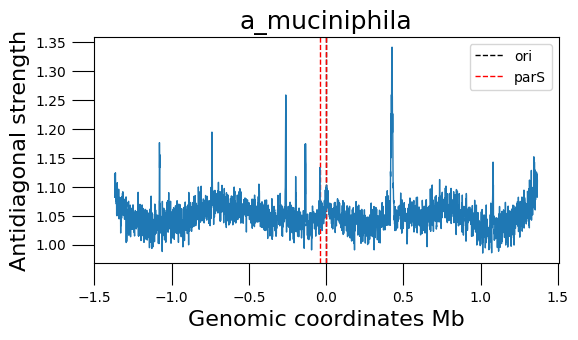

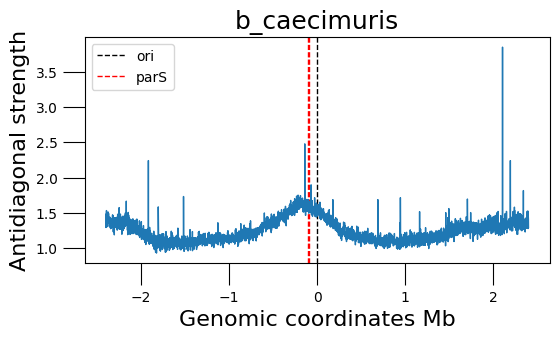

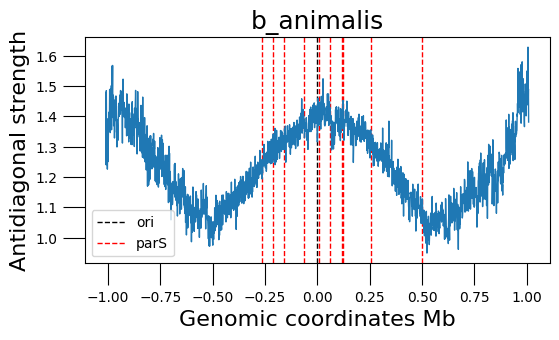

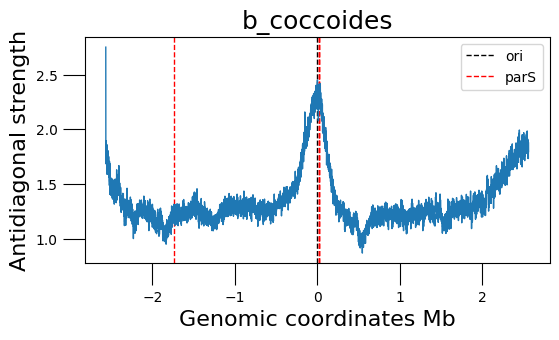

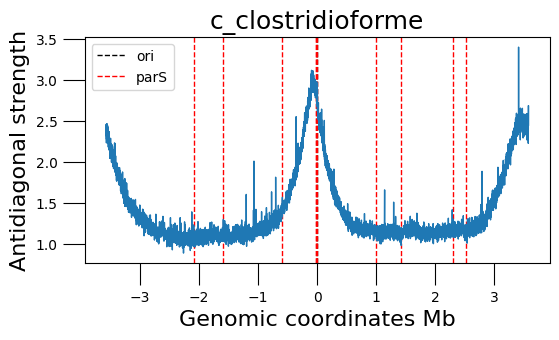

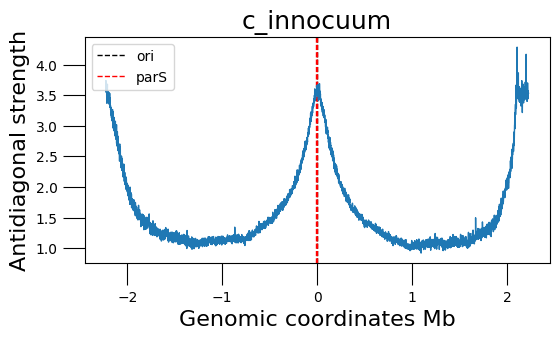

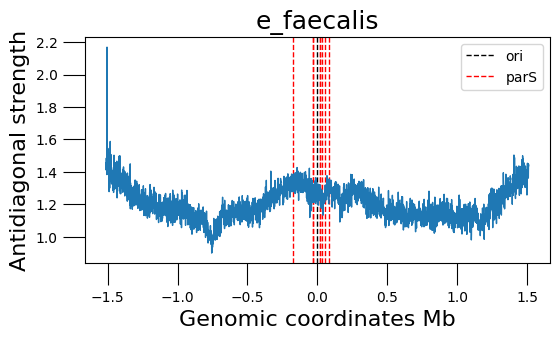

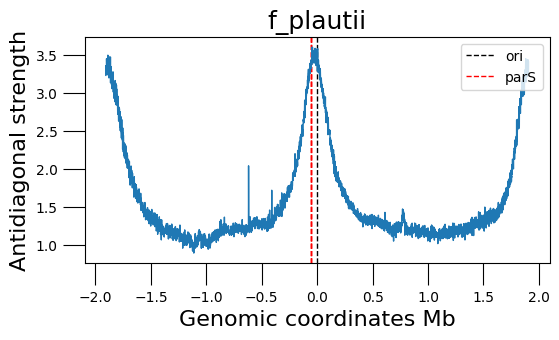

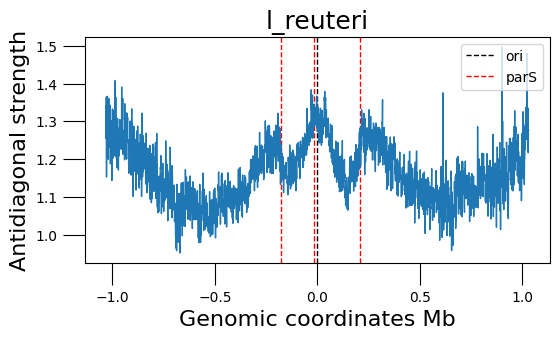

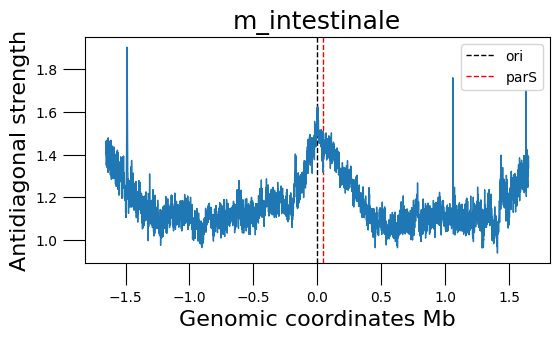

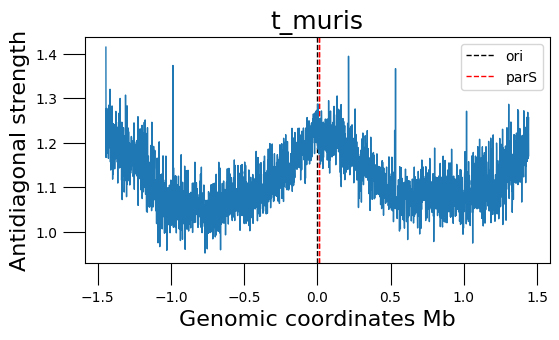

In [16]:
# Compute the values for all bacterias
binning = 2000
all_values = []
for bac in list_bacteria:
    prefix = bac[0] + "_" + bac.split("_")[1]
    
    # Set repository and build the normalized and binned contact map.
    repo = os.path.join("/data/oligomm/", bac, "in_vitro_R1")
    os.chdir(repo)
    M = bcio.build_map(["abs_fragments_contacts_weighted.txt"], "fragments_list.txt", binning)
    n = np.shape(M)[0]
    
    # Plot the bacteria separetely
    val = bca.compute_antidiagonal(M, full=False)
    ori = pd.read_csv("../cov/ratio_ori_ter.txt", sep="\t", header=None).iloc[1,1]
    pars = np.array(pd.read_csv("../annotation/" + prefix + "_pars.bed", sep="\t", header=None).iloc[:,1])
    bcp.antidiagonal_plot(val, binning=binning, title=prefix, ori_pos=ori, pars_pos=pars)
    
    # Search for ori position to put it as a the middle of the vector.
    ratio_ori_ter = pd.read_csv("../cov/ratio_ori_ter.txt", sep="\t", header=None)
    ori_pos = ratio_ori_ter.iloc[1,1] // binning
    if ori_pos > n // 2:
        ori_pos = (n - ori_pos) * 2
    else:
        ori_pos = ((n // 2) - ori_pos) * 2
    if ori_pos > n // 2:
        start = ori_pos - n // 2
    else:
        start = ori_pos + n // 2
    
    # Rotate the matrix to have the secondary diagonal as primary diagonal.
    N = np.rot90(M).T
    
    # Add all the diagonal mean values for one bacteria.
    values = []
    values.append(np.mean(np.diag(N, k=0)))
    for i in range(1, n):
        values.append(np.mean(np.concatenate((np.diag(N, k=i), np.diag(N, k=-n+i)))))
    
    # Normalize by the first quartile.
    values = values / np.percentile(values, 1)
    
    # Put the ori in the middle of the curve
    values = np.concatenate((values[start:], values[:start]))
    values = np.concatenate((values[len(values)//2:], values, values[:len(values)//2]))
    
    # Add the vector in the final list
    all_values.append(values)

### 6 bacteria with strongest diagonals.

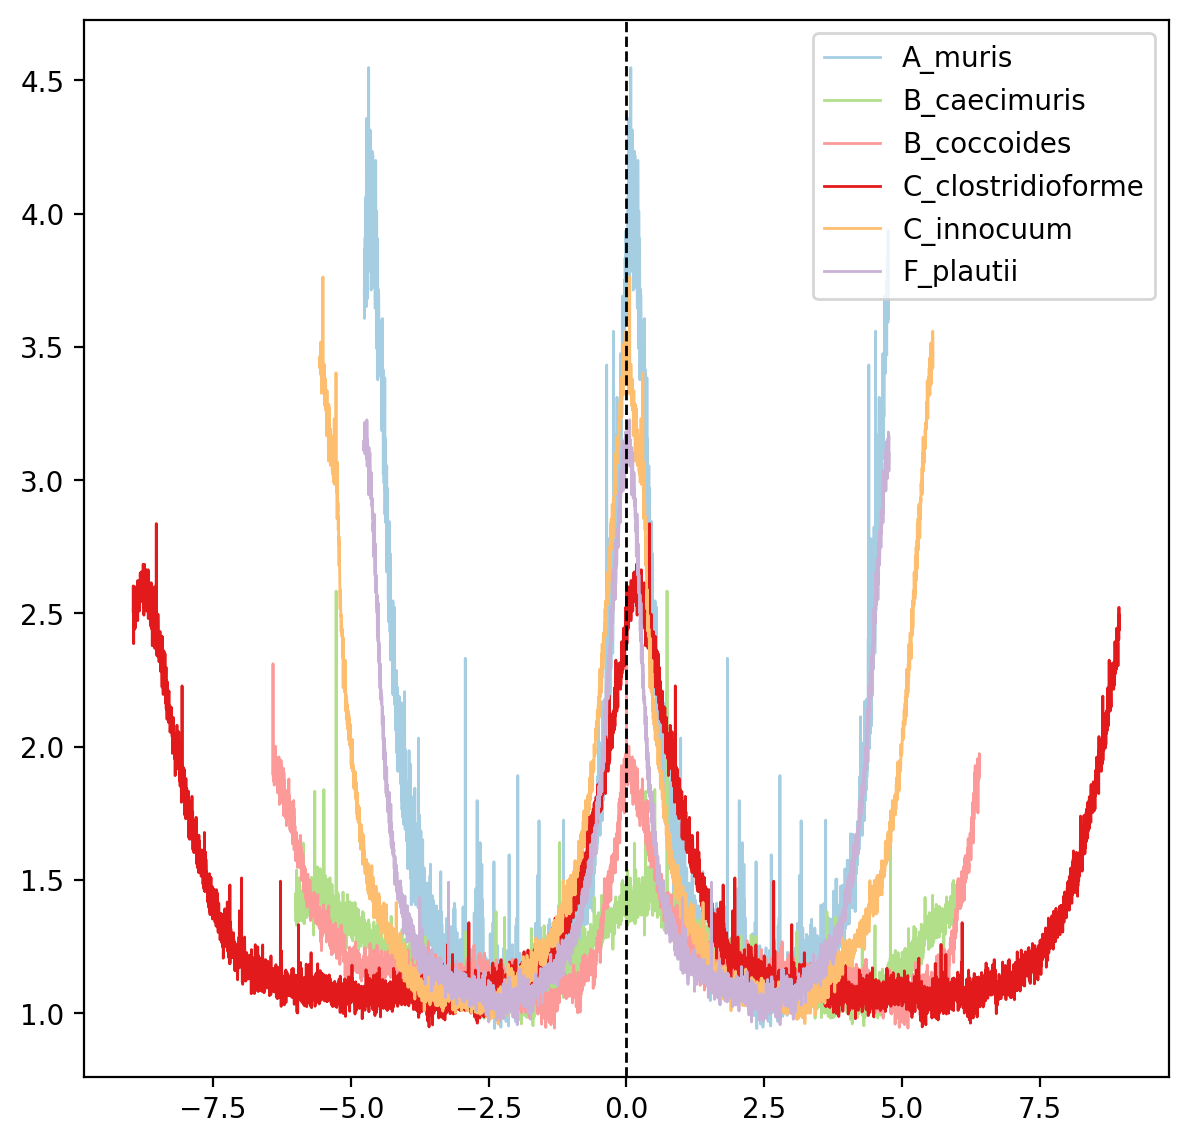

In [17]:
# Plot the curves
color = sns.color_palette("Paired")
plt.figure(figsize=(7, 7), dpi=200)
size = 0
for values in all_values:
    length = len(values)
    size = max(size, length)
x = np.arange(-size // 2, size // 2) * 0.0025
for i, values in enumerate(all_values):
    if i in [0,2,4,5,6,8]:
        bac = list_bacteria[i]
        label = bac.split("_")[0][0].upper() + "_" + bac.split("_")[1]
        blank = np.repeat(np.nan, ((size - len(values)) // 2))
        values = np.concatenate((blank, values, blank))
        if len(values) != len(x):
            values = np.append(values, np.nan)
        plt.plot(x, values, label=label, color=color[i], linewidth=1)
plt.axvline(x=0, linewidth=1, color="black", linestyle="dashed")
plt.legend()
plt.savefig("/data/oligomm/secondary_diagonal_1_with_diag.pdf")

### 6 bacteria with tiniest diagonals.

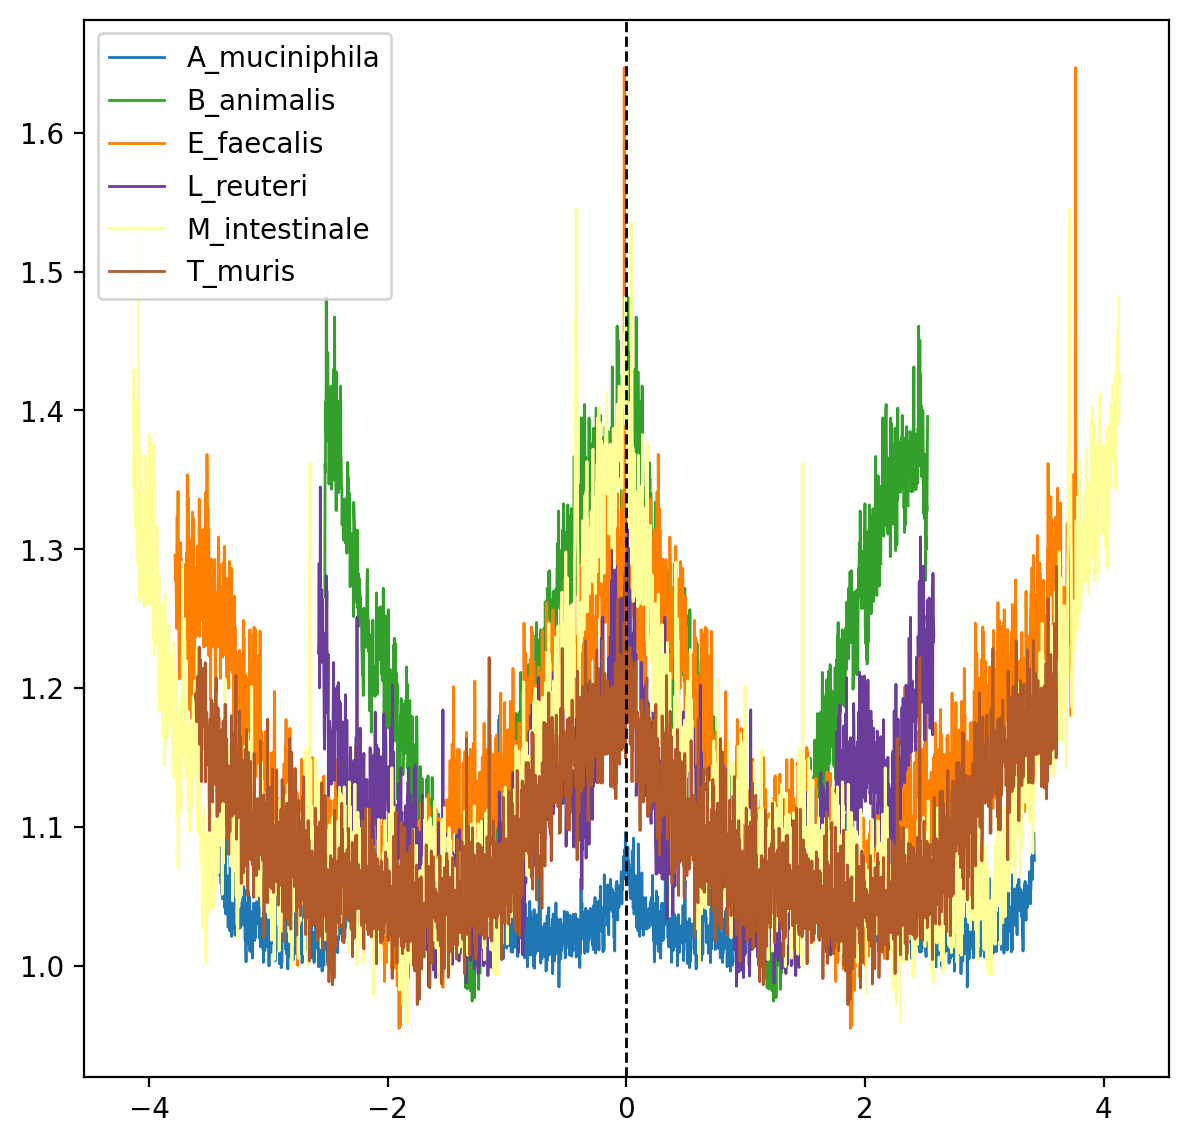

In [18]:
# Plot the curves
color = sns.color_palette("Paired")
plt.figure(figsize=(7, 7), dpi=200)
size = 0
for values in all_values:
    length = len(values)
    size = max(size, length)
x = np.arange(-size // 2, size // 2) * 0.0025
for i, values in enumerate(all_values):
    if i not in [0,2,4,5,6,8]:
        bac = list_bacteria[i]
        label = bac.split("_")[0][0].upper() + "_" + bac.split("_")[1]
        blank = np.repeat(np.nan, ((size - len(values)) // 2))
        values = np.concatenate((blank, values, blank))
        if len(values) != len(x):
            values = np.append(values, np.nan)
        plt.plot(x, values, label=label, color=color[i], linewidth=1)
plt.axvline(x=0, linewidth=1, color="black", linestyle="dashed")
plt.legend()
plt.savefig("/data/oligomm/secondary_diagonal_2_with_diag.pdf")

## Plot all conditions for one bacteria

In [19]:
conditions = [
    "in_vitro_R1",
    "in_vitro_R2",
    "in_vivo_2019_R1",
    "in_vivo_2019_R2",
    "in_vivo_2020_R1",
    "in_vivo_2020_R2",
]

In [20]:
# Initiation
bac = "bacteroidetes_caecimuris"
prefix = bac[0] + "_" + bac.split("_")[1]
binning = 5000

# Search for ori and parS
all_values = []
repo = os.path.join("/data/oligomm/", bac)
os.chdir(repo)
ori = pd.read_csv("cov/ratio_ori_ter.txt", sep="\t", header=None).iloc[1,1]
pars = np.array(pd.read_csv("annotation/" + prefix + "_pars.bed", sep="\t", header=None).iloc[:,1])

# Iterates on conditions
for i in range(len(conditions)):
    repo = os.path.join("/data/oligomm/", bac, conditions[i])
    os.chdir(repo)
    M = bcio.build_map(["abs_fragments_contacts_weighted.txt"], "fragments_list.txt", binning)
    all_values.append(bca.compute_antidiagonal(M, full=True))

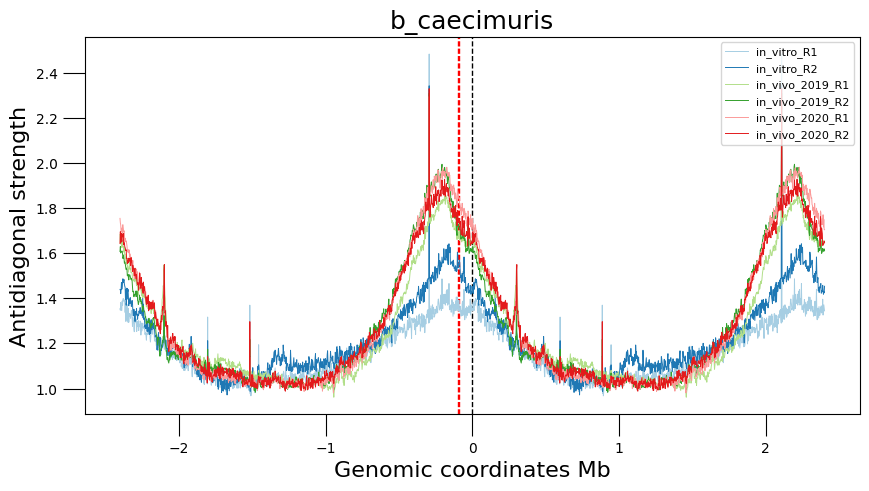

In [21]:
# Display plot based as a scalogram 
bcp.antidiagonal_scalogram(
    all_values,
    binning=binning,
    title=prefix, 
    ori_pos=ori,
    pars_pos=pars, 
    labels=conditions
)